# Introduction to evolutionary simulations with Geonomics (Part 2)

This is the second part of an introduction to evolutionary simulations with Geonomics. In this part, we will be running simulations of natural selection and then you will create and run your own simulations. As a reminder, *Geonomics* allows the user to test hypotheses and run simulations about how the spatial arrangement and size of populations of organisms while incorporating any realistic or modeled geospatial **layers** of a landscape. The so-called forces of evolution can all be simulated: mutation, natural selection, founder effects, genetic drift, and gene-flow. The result is a very flexible platform to allow prediction of evolutionary outcomes across space.

# Glossary

**A glossary of key terms and concepts is available here [Geonomics Glossary Google Doc](https://docs.google.com/document/d/133njF4NFe2SH5zSASTnObL5wGRp3RalnkFM6Aih-Wf0/edit?usp=sharing)




## Important notes: 

*Please don't be overwhelmed by the length of the code blocks in this notebook.* We intentionally left the code for you to see -- and exercises for you to modify the code -- so that you can think about the different parameters than need to be defined to construct a somewhat realistic evolutionary simulation.

You need to read the **text cells** carefully and follow the instructions. Some **code cells** you will *run without changing*. Other times you will need to *edit the cells as instructed* to adjust the parameters of the model so we can simulate different scenarios. Reading the green `# comments` in Geonomics code will help to understand what you are actually doing during model set-up,  running of the model, and model results evaluation, and for **creating your own scenario** at the end. It is not necessary for you to read all of the `# comments` or code during this Notebook, this is what a user of the Geonomics package will refer to while running their simulations. We will also make use of **functions** which are blocks of code that perform a task (you do not need to edit or make your own functions).

## Helpful Reminders: 

### Jupyter notebooks
When a cell is running the circle in the top right of the notebook next to Python 3 will be solid grey. Some cells take several seconds to run. Just be patient.


### Text cells
In a notebook, each rectangle containing text or code is called a *cell*.

Text cells (like this one) can be edited by double-clicking on them. They're written in a simple format called [Markdown](http://daringfireball.net/projects/markdown/syntax) to add formatting and section headings.  You don't need to learn Markdown, but you might want to.

After you edit a text cell, click the "run cell" button at the top to confirm any changes. (Try not to delete the instructions of the lab.)

### Code cells
Other cells contain code in the Python 3 language. Running a code cell will execute all of the code it contains.

To run the code in a code cell, first click on that cell to activate it.  It'll be highlighted with a little green or blue rectangle.  Next, either press the Run button or hold down the `shift` key and press `return` or `enter`.

The only code cells that need to be modified are right below a blue exercise box.

### Comments
Comments are statements in English that the computer ignores. We use comments to explain what the surrounding code does. Comments appear in green after the `#` symbol.

<div class="alert alert-info" role="alert" style="font-size:120%">
  
**Agenda**:
<ul>
    <li>1. run a simulation of natural selection to a heterogeneous environment</li>
    <li>2. create and run your own model scenario</li>
</ul>

<p>

</p>
</div>

### Okay! Now on to the code!

<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Import needed packages</h2></b> 

Run the following cell to bring in the necessary Python packages for our exercise today. Recall that you need to run this cell and any cells above the one you are working on each time you relaunch the notebook.

In [1]:
import geonomics as gnx
import numpy as np
import matplotlib.pyplot as plt
import nlmpy as nlmpy

# and also set Matplotlib's default plotting style and plot size
%matplotlib inline
plt.rcParams["figure.figsize"] = (9,4)

NOTE: Module 'pykrige' not found. Yosemite demo 3d plots cannot be produced.


<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Define some helper functions</h2></b> 

Here we will define some functions to create simple, geometric arrays, which we'll use as landscapes for our simulations.

__No need to alter the code here.__ Just run it. We'll use the functions below.

In [2]:
################################
# RUN THIS CODE WITHOUT CHANGING
################################

def make_unif_array(n):
    """Makes a square array of ones, size n x n cells."""
    array = np.ones((n,n))
    return array

def add_vert_barrier(array, width = 5):
    """Returns a new array, which is the input array but with an added vertical barrier of the defined width."""
    if array.shape[0] % 2 != width % 2:
        width += 1
    assert width <= array.shape[0] - 2, ("The width of the barrier should be "
                                       "at least 2 less than the width of the landscape.")
    left_extent = int((array.shape[0] - width)/2)
    right_extent = left_extent + width
    new_array = np.copy(array)
    new_array[:, left_extent:right_extent] = 0
    return new_array

def make_horz_grad_array(n, grad_width=8):
    """Makes a square array with a horizontal gradient
    running from 0 to 1, size n x n cells."""
    assert grad_width <= n, "Argument 'grad_width' must be <= argument 'n'."
    if n % 2 != grad_width % 2:
        grad_width += 1
    grad_vals = np.linspace(0, 1, grad_width)
    append_len = int((n - grad_width) / 2)
    grad_vals = np.hstack([np.zeros((append_len)), grad_vals, np.ones((append_len))])
    array = np.vstack([grad_vals.T]*n)
    return array

# function for running and plotting genetic PCA
def plot_PCA(mod):
    from copy import deepcopy
    from sklearn.decomposition import PCA
    figsize = 6
    species = mod.comm[0]
    # get array of resulting genomic data (i.e. 'speciome'),
    # genotypes averaged by individual
    speciome = np.mean(species._get_genotypes(), axis=2)
    # run PCA on speciome
    pca = PCA(n_components=2)
    PCs = pca.fit_transform(speciome)
    # normalize the PC results
    norm_PCs = (PCs - np.min(PCs,
                             axis=0)) / (np.max(PCs,
                                                axis=0) - np.min(PCs,
                                                                 axis=0))
    # assign a value to each species, 0 or 1, indicating whether they're located on
    # the left or right vertical half of the landscape
    ind_colors = ['#00ffff' if ind.x < mod.land.dim[0]/2 else '#ff00ff' for ind in species.values()]
    # plot individuals on PCs 1 and 2, colored by their landscape half
    fig = plt.figure(figsize=(figsize, figsize), dpi= 80, facecolor='w', edgecolor='k')
    plt.scatter(norm_PCs[:,0], norm_PCs[:, 1], color = ind_colors)
    plt.xlabel('genetic PC 1')
    plt.ylabel('genetic PC 2')
    
# function for running and plotting genetic PCA
def map_PCA(mod, lyr_num=0, mask=True):
    from copy import deepcopy
    from sklearn.decomposition import PCA
    cmaps = {0: plt.cm.RdBu.copy(), 1: plt.cm.BrBG_r.copy()}
    mark_size = 60
    figsize = 8
    species = mod.comm[0]
    land = mod.land
    # get array of resulting genomic data (i.e. 'speciome'),
    # genotypes meaned by individual
    speciome = np.mean(species._get_genotypes(), axis=2)
    # run PCA on speciome
    pca = PCA(n_components=3)
    PCs = pca.fit_transform(speciome)
    # normalize the PC results
    norm_PCs = (PCs - np.min(PCs,
                             axis=0)) / (np.max(PCs,
                                                axis=0) - np.min(PCs,
                                                                 axis=0))
    # use first 3 PCs to get normalized values for R, G, & B colors
    PC_colors = norm_PCs * 255
    # scatter all individuals on top of landscape, colored by the
    # RBG colors developed from the first 3 geonmic PCs
    xs = mod.comm[0]._get_x()
    ys = mod.comm[0]._get_y()
    # get environmental raster, with barrier masked out
    env = deepcopy(mod.land[lyr_num].rast)
    if mask:
        env[mod.land[lyr_num].rast == 0] = np.nan
    # create light colormap for plotting landscape
    # bot = plt.cm.get_cmap('Blues', 256)(np.linspace(0.4, 0.45, 2))[0]
    # top = plt.cm.get_cmap('Reds', 256)(np.linspace(0.4, 0.45, 2))[0]
    # cols = np.vstack((top, bot))
    # cmap = mpl.colors.ListedColormap(cols, name='OrangeBlue')
    cmap = cmaps[lyr_num]
    cmap.set_bad(color='#8C8C8C')
    # plot landscape
    fig = plt.figure(figsize=(figsize, figsize), dpi= 80, facecolor='w', edgecolor='k')
    # plt.imshow(masked_env, cmap=cmap, alpha=0.8)
    plt.pcolormesh(land._x_cell_bds, land._y_cell_bds, env, cmap=cmap)
    # scatter plot of individuals, colored by composite PC score
    plt.scatter(xs, ys, c=PC_colors/255.0, s=mark_size, edgecolors='black')
    # fix x and y limits
    [f([dim - 0.5 for dim in (0, mod.land.dim[0])]) for f in (plt.xlim,
                                                              plt.ylim)]
    # get rid of x and y ticks
    [f([]) for f in (plt.xticks, plt.yticks)]



<div class="alert alert-danger" role="alert" style="font-size:120%">
    <b><h2>Part 1: Natural Selection</h2></b> 

**Natural selection occurs because**:
1. Individuals vary phenotypically.
2. The phenotypic variation has some genotypic underpinning.
3. Genotypic variations are heritable.
4. Variation among individuals makes some more likely to survive and reproduce than others (i.e. more fit).
5. More fit individuals pass on their genes more often.
6. Over time, this changes the genetic and phenotypic composition of a population and, thus, of a species.

Geonomics will simulate that process - in space! As you're watching these simulations, keep in mind the concepts you explored in the previous labs about gene flow and genetic drift. Those things still happen in this model, but natural selection adds an extra level of complexity. It can change the probability that certain genes move and persist on the landscape and, thus, the nature of isolation between different neighborhoods on the landscape.

The code in the following cells is very similar to what we saw in the first section. As before, run the code, changing any values as directed.


<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Set the parameter values</h2></b> 

This time, we'll create a model with <u>__two landscape layers__</u>:

1. A layer to describe the __habitat configuration__, which will determine both the species' local population density and its movement throughout the landscape. For the sake of simplicity, we will use a uniform layer for these simulations.
    
2. A layer to describe an __environmental gradient__ across the landscape, which will exert divergent selection on the species. We will use a linear gradient for these simulations.
    
We again want a model with a <u>__single species__</u>, but this time that species will have __one trait__. Each individual's phenotype for this trait will determined by its genotype at the genetic loci that underlie the trait, and its probability of survival will be determined by the difference between that phenotype and the optimal phenotype at the individual's location, according to the environmental gradient layer. Thus, the environmental gradient will exert divergent natural selection on this trait (selection for different phenotypes in different places).

We will simulate a single mouse species that will have a single trait: color. For the sake of simplicity, our mice have a single gene that controls color, which has three variations - white, green, and brown.  The second layer of our model defines the ground color across our landscape: one side is green, one side is brown, and the middle is white.  Mice survive best when their color matches the ground color. i.e. Green mice are favored on green ground, white mice are favored on white ground, and brown mice are favored on brown ground.  This is selective pressure.  In the simulation model we can define how strong this pressure is.  Those individuals that are best adapted to their location will survive longer and have more offspring, so the variations in the landscape are critical.


To accomplish all of that, we have changed the following parameter values (Reminder: you do not need to make any changes to the code, these definitions are to help you understand all the parameters of the model):

- **rast** parameter in the __'lyr_0'__ section: *We set this to a uniform raster, using __`make_unif_array(40)`__*.

- **rast** parameter in the __'lyr_1'__ section: *We set this to a horizontal gradient, using __`make_horz_grad_array(40)`__*

- **layer** parameter in the __'trait_0'__ section: *We set this to __`'lyr_1'`__, to indicate that layer 1 should serve as trait 0's selective force*


In [3]:
# selection_demo.py

# This is a parameters file generated by Geonomics
# (by the gnx.make_parameters_file() function).


                   #   ::::::          :::    :: :::::::::::#
             #::::::    ::::   :::      ::    :: :: ::::::::::: ::#
          #:::::::::     ::            ::   :::::::::::::::::::::::::#
        #::::::::::                      :::::::::: :::::: ::::::::  ::#
      #  : ::::  ::                    ::::  : ::    :::::::: : ::  :    #
     # GGGGG :EEEE: OOOOO   NN   NN   OOOOO   MM   MM IIIIII  CCCCC SSSSS #
    # GG     EE    OO   OO  NNN  NN  OO   OO  MM   MM   II   CC     SS     #
    # GG     EE   OO     OO NN N NN OO     OO MMM MMM   II   CC     SSSSSS #
    # GG GGG EEEE OO     OO NN  NNN OO     OO MM M MM   II   CC         SS #
    # GG   G EE    OO   OO  NN   NN  OO   OO  MM   MM   II   CC        SSS #
     # GGGGG :EEEE: OOOOO   NN   NN   OOOOO   MM   MM IIIIII  CCCCC SSSSS #
      #    : ::::::::               :::::::::: ::              ::  :   : #
        #:    :::::                    :::::: :::             :::::::  #
          #    :::                      :::::  ::              ::::: #
             #  ::                      ::::                      #
                   #                                        #
                      #  :: ::    :::             #


params = {
#--------------------------------------------------------------------------#

#-----------------#
#--- LANDSCAPE ---#
#-----------------#
    'landscape': {

    #------------#
    #--- main ---#
    #------------#
        'main': {
            #x,y (a.k.a. j,i) dimensions of the Landscape
            'dim':                      (40,40),
            #x,y resolution of the Landscape
            'res':                      (1,1),
            #x,y coords of upper-left corner of the Landscape
            'ulc':                      (0,0),
            #projection of the Landscape
            'prj':                      None,
            }, # <END> 'main'

    #--------------#
    #--- layers ---#
    #--------------#
        'layers': {

            #layer name (LAYER NAMES MUST BE UNIQUE!)
            'lyr_0': {

        #-------------------------------------#
        #--- layer num. 0: init parameters ---#
        #-------------------------------------#

                #initiating parameters for this layer
                'init': {

                    #parameters for a 'defined'-type Layer
                    'defined': {
                        #raster to use for the Layer
                        'rast':                   make_unif_array(40),
                        #point coordinates
                        'pts':                    None,
                        #point values
                        'vals':                   None,
                        #interpolation method {None, 'linear', 'cubic',
                        #'nearest'}
                        'interp_method':          None,

                        }, # <END> 'defined'

                    }, # <END> 'init'

                }, # <END> layer num. 0


            #layer name (LAYER NAMES MUST BE UNIQUE!)
            'lyr_1': {

        #-------------------------------------#
        #--- layer num. 1: init parameters ---#
        #-------------------------------------#

                #initiating parameters for this layer
                'init': {

                    #parameters for a 'defined'-type Layer
                    'defined': {
                        #raster to use for the Layer
                        'rast':                   make_horz_grad_array(40),
                        #point coordinates
                        'pts':                    None,
                        #point values
                        'vals':                   None,
                        #interpolation method {None, 'linear', 'cubic',
                        #'nearest'}
                        'interp_method':          None,

                        }, # <END> 'defined'

                    }, # <END> 'init'

                }, # <END> layer num. 1



    #### NOTE: Individual Layers' sections can be copy-and-pasted (and
    #### assigned distinct keys and names), to create additional Layers.


            } # <END> 'layers'

        }, # <END> 'landscape'


#-------------------------------------------------------------------------#
    
#-----------------#
#--- COMMUNITY ---#
#-----------------#
    'comm': {

        'species': {

            #species name (SPECIES NAMES MUST BE UNIQUE!)
            'spp_0': {

            #-----------------------------------#
            #--- spp num. 0: init parameters ---#
            #-----------------------------------#

                'init': {
                    #starting number of individs
                    'N':                250,
                    #carrying-capacity Layer name
                    'K_layer':          'lyr_0',
                    
###########################################################################
# CONSIDER CHANGING THIS PARAMETER                                        #
                    #multiplicative factor for carrying-capacity layer    #
                    'K_factor':         1,                                #
###########################################################################
                    
                    }, # <END> 'init'

            #-------------------------------------#
            #--- spp num. 0: mating parameters ---#
            #-------------------------------------#

                'mating'    : {
                    #age(s) at sexual maturity (if tuple, female first)
                    'repro_age':                0,
                    #whether to assign sexes
                    'sex':                      False,
                    #ratio of males to females
                    'sex_ratio':                1/1,
                    #whether P(birth) should be weighted by parental dist
                    'dist_weighted_birth':       False,
                    #intrinsic growth rate
                    'R':                        0.5,
                    #intrinsic birth rate (MUST BE 0<=b<=1)
                    'b':                        0.2,
                    #expectation of distr of n offspring per mating pair
                    'n_births_distr_lambda':    1,
                    #whether n births should be fixed at n_births_dist_lambda
                    'n_births_fixed':           True,
                    #whether individs should choose nearest neighs as mates
                    'choose_nearest_mate':        False,
                    #whether mate-choice should be inverse distance-weighted
                    'inverse_dist_mating':      False,

                    
########################################################
# CONSIDER CHANGING THIS PARAMETER                     #
                    #radius of mate-search area        #   
                    'mating_radius':            10,    #
########################################################            
                    
                    }, # <END> 'mating'

            #----------------------------------------#
            #--- spp num. 0: mortality parameters ---#
            #----------------------------------------#

                'mortality'     : {
                    #maximum age
                    'max_age':                      None,
                    #min P(death) (MUST BE 0<=d_min<=1)
                    'd_min':                        0,
                    #max P(death) (MUST BE 0<=d_max<=1)
                    'd_max':                        1,
                    #width of window used to estimate local pop density
                    'density_grid_window_width':    None,
                    }, # <END> 'mortality'

            #---------------------------------------#
            #--- spp num. 0: movement parameters ---#
            #---------------------------------------#

                'movement': {
                    #whether or not the species is mobile
                    'move':                                 True,
                    #mode of distr of movement direction
                    'direction_distr_mu':                   0,
                    #concentration of distr of movement direction
                    'direction_distr_kappa':                0,
##################################################################
# CONSIDER CHANGING THIS PARAMETER                               #
                    #1st param of distr of movement distance     #   
                    'movement_distance_distr_param1':       0.5, #
##################################################################
                    #2nd param of distr of movement distance
                    'movement_distance_distr_param2':       5e-8,
                    #movement distance distr to use ('levy' or 'wald')
                    'movement_distance_distr':              'levy',
                    #1st param of distr of dispersal distance
                    'dispersal_distance_distr_param1':      0,
                    #2nd param of distr of dispersal distance
                    'dispersal_distance_distr_param2':      5e-14,
                    #dispersal distance distr to use ('levy' or 'wald')
                    'dispersal_distance_distr':             'levy',
                    'move_surf'     : {
                        #move-surf Layer name
                        'layer':                'lyr_0',
                        #whether to use mixture distrs
                        'mixture':              True,
                        #concentration of distrs
                        'vm_distr_kappa':       12,
                        #length of approximation vectors for distrs
                        'approx_len':           5000,
                        }, # <END> 'move_surf'

                    },    # <END> 'movement'


            #---------------------------------------------------#
            #--- spp num. 0: genomic architecture parameters ---#
            #---------------------------------------------------#

                'gen_arch': {
                    #file defining custom genomic arch
                    'gen_arch_file':            None,
                    #num of loci
                    'L':                        100,
                    #starting allele frequency (None to draw freqs randomly)
                    'start_p_fixed':            0.5,
                    #whether to start neutral locus freqs at 0
                    'start_neut_zero':          False,
                    #genome-wide per-base neutral mut rate (0 to disable)
                    'mu_neut':                  0,
                    #genome-wide per-base deleterious mut rate (0 to disable)
                    'mu_delet':                 0,
                    #shape of distr of deleterious effect sizes
                    'delet_alpha_distr_shape':  0.2,
                    #scale of distr of deleterious effect sizes
                    'delet_alpha_distr_scale':  0.2,
                    #alpha of distr of recomb rates
                    'r_distr_alpha':            None,
                    #beta of distr of recomb rates
                    'r_distr_beta':             None,
                    #whether loci should be dominant (for allele '1')
                    'dom':                      False,
                    #whether to allow pleiotropy
                    'pleiotropy':               False,
                    #custom fn for drawing recomb rates
                    'recomb_rate_custom_fn':    None,
                    #number of recomb paths to hold in memory
                    'n_recomb_paths_mem':       int(1e4),
                    #total number of recomb paths to simulate
                    'n_recomb_paths_tot':       int(1e5),
                    #num of crossing-over events (i.e. recombs) to simulate
                    'n_recomb_sims':            10_000,
                    #whether to generate recombination paths at each timestep
                    'allow_ad_hoc_recomb':      False,
                    #whether to jitter recomb bps, to correctly track num_trees
                    'jitter_breakpoints':       False,
                    #whether to save mutation logs
                    'mut_log':                  False,
                    #whether to use tskit (to record full spatial pedigree)
                    'use_tskit':                True,
                    #time step interval for simplication of tskit tables
                    'tskit_simp_interval':      100,



                    'traits': {

                        #--------------------------#
                        #--- trait 0 parameters ---#
                        #--------------------------#
                        #trait name (TRAIT NAMES MUST BE UNIQUE!)
                        'trait_0': {
                            #trait-selection Layer name
                            'layer':                'lyr_1',
#################################################################
# CONSIDER CHANGING THESE PARAMETERS                            #
                            #polygenic selection coefficient    #
                            'phi':                  0.05,       # 
                            #number of loci underlying trait    #
                            'n_loci':               1,          #
#################################################################
                            #mutation rate at loci underlying trait
                            'mu':                   0,
                            #mean of distr of effect sizes
                            'alpha_distr_mu' :      0.1,
                            #variance of distr of effect size
                            'alpha_distr_sigma':    0,
                            #max allowed magnitude for an alpha value
                            'max_alpha_mag':        None,
                            #curvature of fitness function
                            'gamma':                1,
                            #whether the trait is universally advantageous
                            'univ_adv':             False
                            }, # <END> trait 0


    #### NOTE: Individual Traits' sections can be copy-and-pasted (and
    #### assigned distinct keys and names), to create additional Traits.


                        }, # <END> 'traits'

                    }, # <END> 'gen_arch'


                }, # <END> spp num. 0



    #### NOTE: individual Species' sections can be copy-and-pasted (and
    #### assigned distinct keys and names), to create additional Species.


            }, # <END> 'species'

        }, # <END> 'comm'


#------------------------------------------------------------------------#

#-------------#
#--- MODEL ---#
#-------------#
    'model': {
        #total Model runtime (in timesteps)
        'T':            100,
        #min burn-in runtime (in timesteps)
        'burn_T':       30,
        #seed number
        'num':          None,


        #-----------------------------#
        #--- iterations parameters ---#
        #-----------------------------#
        'its': {
            #num iterations
            'n_its':            1,
            #whether to randomize Landscape each iteration
            'rand_landscape':   False,
            #whether to randomize Community each iteration
            'rand_comm':        False,
            #whether to randomize GenomicArchitectures each iteration
            'rand_genarch':     True,
            #whether to burn in each iteration
            'repeat_burn':      False,
            }, # <END> 'iterations'



        } # <END> 'model'

    } # <END> params


<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Make the model</h2></b> 

Run the following code again to make the model.

In [4]:
#make our params dict into a proper Geonomics ParamsDict object
params = gnx.make_params_dict(params, 'selection_demo')
#then use it to make a model
mod = gnx.make_model(parameters=params, verbose=True)


MAKING MODEL...

	MAKING LANDSCAPE...

	MAKING COMMUNITY...

		MAKING SPECIES spp_0...

			making genomic architecture...



stty: 'standard input': Inappropriate ioctl for device


			making individuals...

			making movement surface...
				[can take a bit]



Then take a look at the model.

<class 'geonomics.sim.model.Model'>
Model name:                                     selection_demo
Layers:                                         0: 'lyr_0'
                                                1: 'lyr_1'
Species:                                        0: 'spp_0'
Number of iterations:                           1
Number of burn-in timesteps (minimum):          30
Number of main timesteps:                       100
Geo-data collected:                             {}
Gen-data collected:                             {}
Stats collected:                                {}


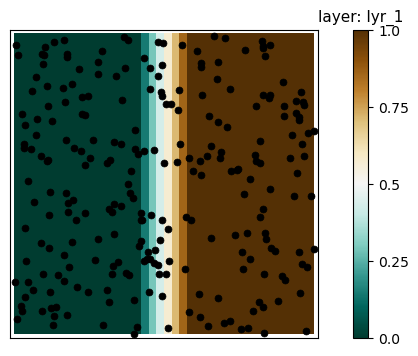

In [5]:
print(mod)
%matplotlib inline
mod.plot(spp=0, lyr=1)

As a reminder, each point is an individual. The background is the environmental gradient that will exert divergent natural selection on the species.

<div class="alert alert-warning" role="alert" style="font-size:120%">
    <b><h2>Run the model</h2></b> 

Now we'll run the burn-in phase of the simulation, and then see what we've got:

In [6]:
#SCROLL DOWN TO FOLLOW BURN-IN AND SEE PLOT

mod.walk(T=10000, mode='burn')



No mod.burn_fn_queue was found. Running mod.reset()...


Creating the burn-in function queue...


Creating the main function queue...


burn:	it=-1:	t=0
	species: spp_0                         N=297	(births=47	deaths=0)

	........................................................................
burn:	it=-1:	t=1
	species: spp_0                         N=356	(births=59	deaths=0)

	........................................................................
burn:	it=-1:	t=2
	species: spp_0                         N=420	(births=64	deaths=0)

	........................................................................
burn:	it=-1:	t=3
	species: spp_0                         N=494	(births=74	deaths=0)

	........................................................................
burn:	it=-1:	t=4
	species: spp_0                         N=579	(births=97	deaths=12)

	........................................................................
burn:	it=-1:	t=5
	species: spp_0                         N=692	(bi

/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):


burn:	it=-1:	t=30
	species: spp_0                         N=1552	(births=307	deaths=306)

	........................................................................
burn:	it=-1:	t=31
	species: spp_0                         N=1556	(births=353	deaths=349)

	........................................................................


/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):


burn:	it=-1:	t=32
	species: spp_0                         N=1537	(births=284	deaths=303)

	........................................................................
burn:	it=-1:	t=33
	species: spp_0                         N=1543	(births=283	deaths=277)

	........................................................................


/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.

burn:	it=-1:	t=34
	species: spp_0                         N=1560	(births=294	deaths=277)

	........................................................................


/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):


burn:	it=-1:	t=35
	species: spp_0                         N=1530	(births=291	deaths=321)

	........................................................................
burn:	it=-1:	t=36
	species: spp_0                         N=1572	(births=317	deaths=275)

	........................................................................


/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.

burn:	it=-1:	t=37
	species: spp_0                         N=1554	(births=313	deaths=331)

	........................................................................
burn:	it=-1:	t=38
	species: spp_0                         N=1536	(births=313	deaths=331)

	........................................................................


/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.

burn:	it=-1:	t=39
	species: spp_0                         N=1575	(births=308	deaths=269)

	........................................................................


/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):


burn:	it=-1:	t=40
	species: spp_0                         N=1565	(births=314	deaths=324)

	........................................................................


/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):


burn:	it=-1:	t=41
	species: spp_0                         N=1608	(births=318	deaths=275)

	........................................................................


/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ttest_res = ttest(data[int(-num_timesteps_back):
/opt/conda/lib/python3.12/site-packages/geonomics/sim/burnin.py:85: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.

burn:	it=-1:	t=42
	species: spp_0                         N=1586	(births=296	deaths=318)

	........................................................................
burn:	it=-1:	t=43
	species: spp_0                         N=1586	(births=308	deaths=308)

	........................................................................
burn:	it=-1:	t=44
	species: spp_0                         N=1574	(births=303	deaths=315)

	........................................................................
burn:	it=-1:	t=45
	species: spp_0                         N=1581	(births=315	deaths=308)

	........................................................................
burn:	it=-1:	t=46
	species: spp_0                         N=1541	(births=315	deaths=355)

	........................................................................
burn:	it=-1:	t=47
	species: spp_0                         N=1560	(births=327	deaths=308)

	........................................................................
burn:	it=-1:	t=4

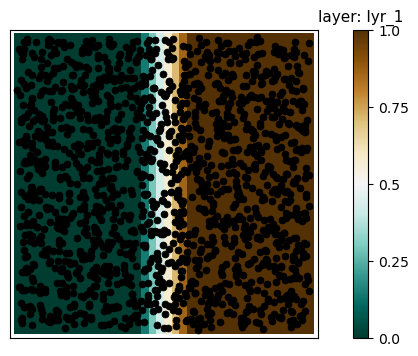

In [7]:
mod.plot(spp=0, lyr=1)

Before we start running the main section of the model, we can use a built-in Geonomics function to make a map of the individuals, colored by their phenotypes for the trait.

**The closer an individual's color is to its environmental background, the closer that individual is to the optimum phenotype for its location, and thus the higher the individual's fitness.**

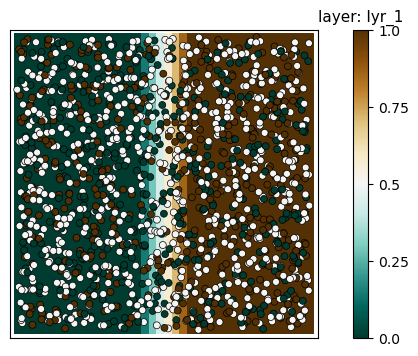

In [8]:
mod.plot_phenotype(spp=0, trt=0)

And let's also create our genetic relatedness plots. As a reminder, in the first plot (pink and blue points), each point is an individual plotted in PCA space and the closer the individuals are together on the plot, the more similar they are genetically. In the second plot (rainbow points), the individuals are shown plotted on the landscape and the more similar their colors are the more similar they are genetially. This is a way to visualize the genetic structure of the population.

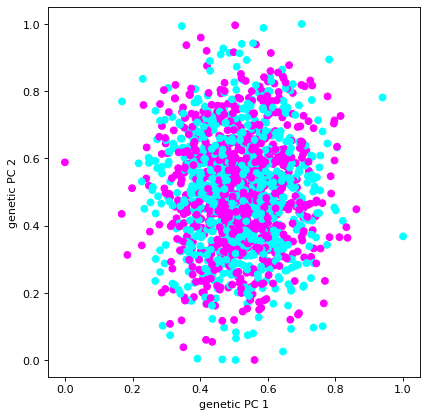

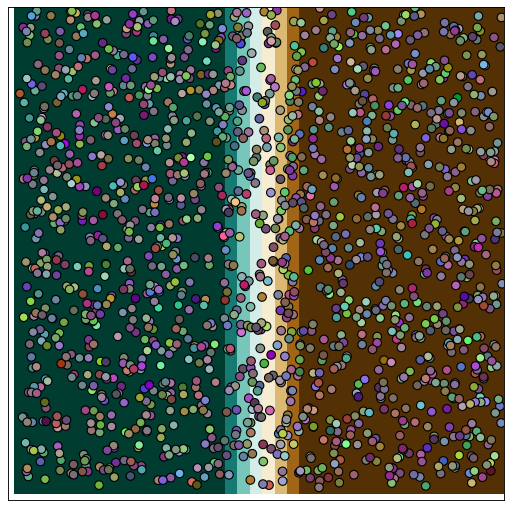

In [9]:
plot_PCA(mod)
map_PCA(mod, lyr_num=1, mask=False)

Now, let's run our model for 50 timesteps, then create our plots again, up until time step 150. Keep a close eye on all three plots, and try and spot the changes in mismatch and structure as you run the simulation.

In [10]:
mod.walk(50)



main:	it=-1:	t=0
	species: spp_0                         N=1541	(births=296	deaths=302)

	........................................................................
main:	it=-1:	t=1
	species: spp_0                         N=1520	(births=332	deaths=353)

	........................................................................
main:	it=-1:	t=2
	species: spp_0                         N=1511	(births=289	deaths=298)

	........................................................................
main:	it=-1:	t=3
	species: spp_0                         N=1539	(births=306	deaths=278)

	........................................................................
main:	it=-1:	t=4
	species: spp_0                         N=1538	(births=315	deaths=316)

	........................................................................
main:	it=-1:	t=5
	species: spp_0                         N=1524	(births=295	deaths=309)

	........................................................................
main:	it=-1:	t=6
	sp

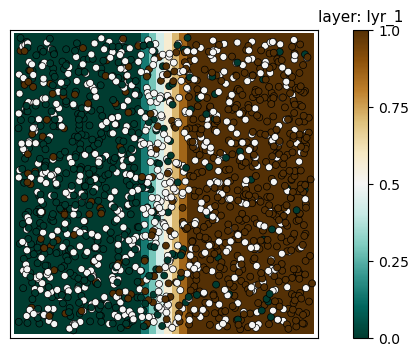

In [11]:
mod.plot_phenotype(spp=0, trt=0)

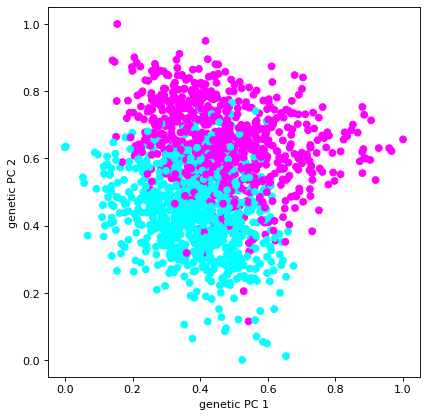

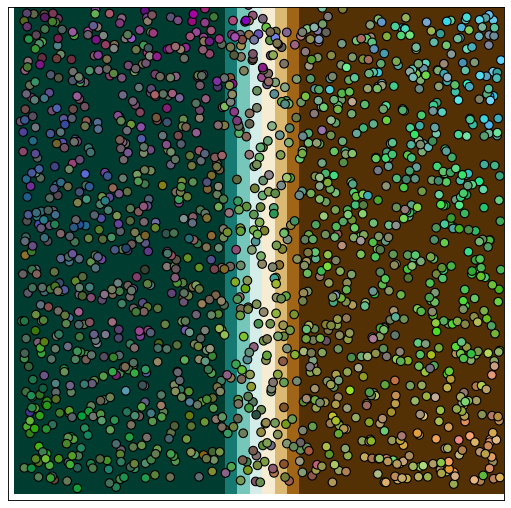

In [12]:
plot_PCA(mod)
map_PCA(mod, lyr_num=1, mask=False)

In [12]:
mod.walk(50)



main:	it=-1:	t=50
	species: spp_0                         N=1543	(births=300	deaths=308)

	........................................................................
main:	it=-1:	t=51
	species: spp_0                         N=1561	(births=323	deaths=305)

	........................................................................
main:	it=-1:	t=52
	species: spp_0                         N=1548	(births=299	deaths=312)

	........................................................................
main:	it=-1:	t=53
	species: spp_0                         N=1589	(births=318	deaths=277)

	........................................................................
main:	it=-1:	t=54
	species: spp_0                         N=1517	(births=326	deaths=398)

	........................................................................
main:	it=-1:	t=55
	species: spp_0                         N=1535	(births=293	deaths=275)

	........................................................................
main:	it=-1:	t

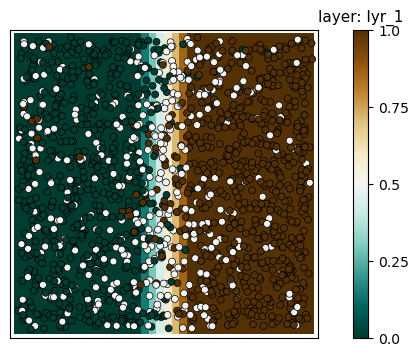

In [13]:
mod.plot_phenotype(spp=0, trt=0)

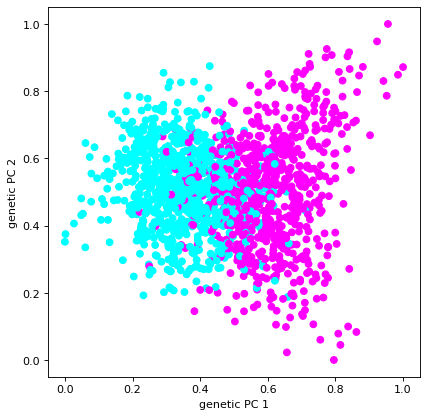

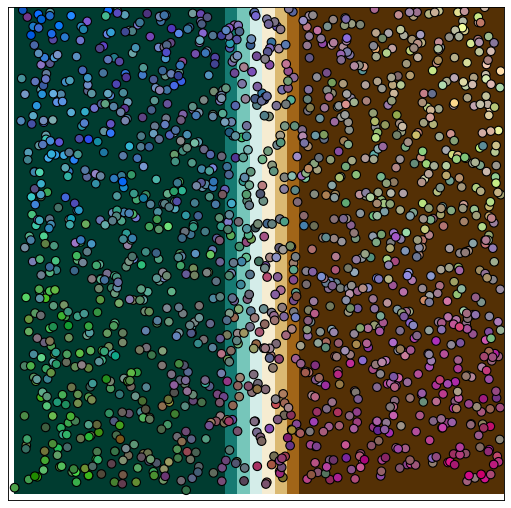

In [15]:
plot_PCA(mod)
map_PCA(mod, lyr_num=1, mask=False)

In [16]:
mod.walk(50)



main:	it=-1:	t=150
	species: spp_0                         N=1556	(births=289	deaths=262)

	........................................................................
main:	it=-1:	t=151
	species: spp_0                         N=1573	(births=328	deaths=311)

	........................................................................
main:	it=-1:	t=152
	species: spp_0                         N=1590	(births=304	deaths=287)

	........................................................................
main:	it=-1:	t=153
	species: spp_0                         N=1611	(births=349	deaths=328)

	........................................................................
main:	it=-1:	t=154
	species: spp_0                         N=1580	(births=328	deaths=359)

	........................................................................
main:	it=-1:	t=155
	species: spp_0                         N=1541	(births=280	deaths=319)

	........................................................................
main:	it

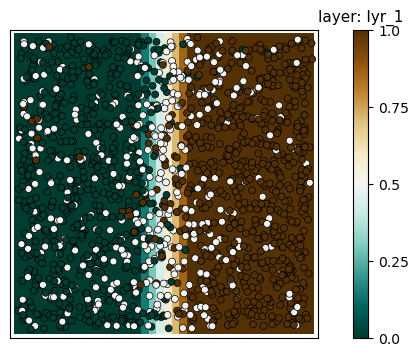

In [15]:
#trt - trait (in this case, trait 0)
mod.plot_phenotype(spp=0, trt=0)

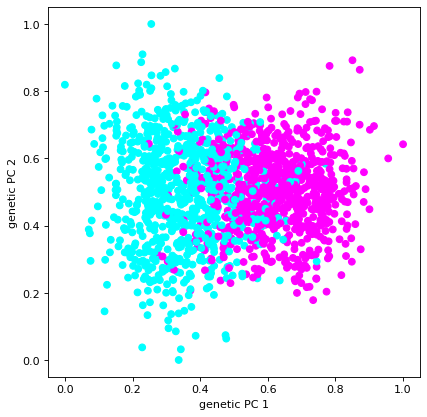

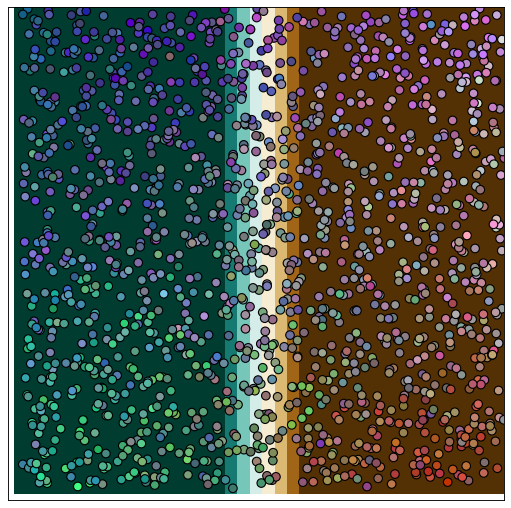

In [18]:
plot_PCA(mod)
map_PCA(mod, lyr_num=1, mask=False)

<!-- BEGIN QUESTION -->

<div class="alert alert-block alert-warning">
    <b> Use the plots above to answer Question 1 </b>
    <br />    
</div>

<div class="alert alert-block alert-info">
    <b>EXERCISE:</b>
    <br />
    Tweak the model and rerun.
    Create your own scenario, by changing one of the following parameters</u> as you wish in the code chunk below and then run a new model. Note that <b>each of these parameters is also outlined by a comment box within the original parameter code above</b>.

    
<b>Parameters to tweak</b>:
- ***phi***: *This controls the strength of selection on the trait. It can be set to 0 <= value <= 1.*

- ***n_loci***: *This controls the number of genetic loci underlying the trait's phenotype. For this simulation, it can be set to 1 <= value <= 100.* (Remember, most traits are not controlled by a single gene, so this can be an important factor in the real world)

- ***K_factor***: *This controls the population density, by setting the number of individuals that can inhabit each cell. It can be set to any value > 0, technically, but values larger than 3 or 4 will probably require too much memory to run on this server, so be careful!*  Higher and lower population density can have a number of impacts- like ability to find mates, availability of resources, etc.  Founder effects are hugely important here as well.

- ***movement_distance_distr_param_1***: *This controls the average distance that an individual moves each time step (in units of cell-widths), and thus how mobile the species is. For this simulation, it can be set to any value > 0 (but very large values might cause problems!).*

- ***mating_radius***: *This controls the radius (expressed in cell-width units) within which an indivudal can choose a mate. For this simulation, it can be set to any value > 0.*

If you are comfortable in Python, you can use the params dictionary above to also toy with any other parameters. But please know that by doing so you may break the code and be unable to run your simulation.
</div>

<!-- BEGIN QUESTION -->

<div class="alert alert-block alert-warning">
    <b> _Before you run your model, answer Question 2. Then, run your model and answer Question 3. Repeat this process for Question 4. </b>
    <br />    
</div>

In [46]:
# to change selection strength (phi), change 0.05 to any value between 0 and 1
params['comm']['species']['spp_0']['gen_arch']['traits']['trait_0']['phi'] = 0.05
# to change the number of loci (n_loci), change 1 to any value between 1 and 100
params['comm']['species']['spp_0']['gen_arch']['traits']['trait_0']['n_loci'] = 1
# to change the carrying capacity factor (K), change 1 to any value greater than 0
params['comm']['species']['spp_0']['init']['K_factor'] = 1
# to change the mean movement distance (movement_distance_distr_param1), change 0.5 to any value greater than 0
params['comm']['species']['spp_0']['movement']['movement_distance_distr_param1'] = 0.5
# to change the mating radius (mating_radius), change 10 to any value greater than 0
params['comm']['species']['spp_0']['mating']['mating_radius'] = 10


MAKING MODEL...

	MAKING LANDSCAPE...

	MAKING COMMUNITY...

		MAKING SPECIES spp_0...

			making genomic architecture...



stty: 'standard input': Inappropriate ioctl for device


			making individuals...

			making movement surface...
				[can take a bit]



No mod.burn_fn_queue was found. Running mod.reset()...


Creating the burn-in function queue...


Creating the main function queue...


burn:	it=-1:	t=0
	species: spp_0                         N=250	(births=51	deaths=1)

	........................................................................
burn:	it=-1:	t=1
	species: spp_0                         N=300	(births=46	deaths=1)

	........................................................................
burn:	it=-1:	t=2
	species: spp_0                         N=345	(births=71	deaths=1)

	........................................................................
burn:	it=-1:	t=3
	species: spp_0                         N=415	(births=84	deaths=1)

	........................................................................
burn:	it=-1:	t=4
	species: spp_0                         N=498	(births=104	deaths=2)

	.............................................................

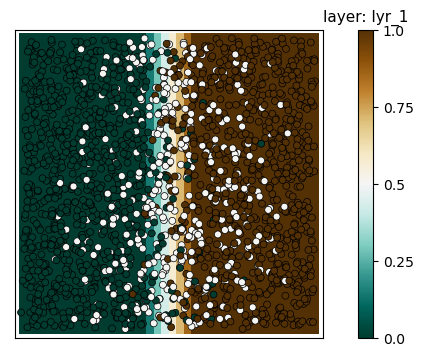

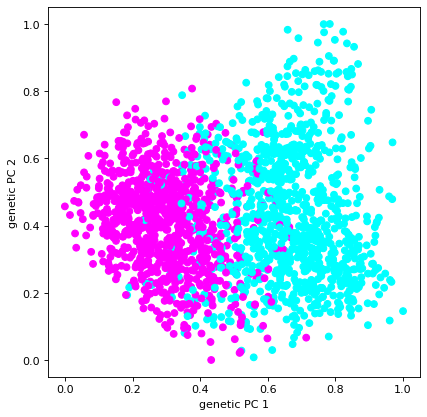

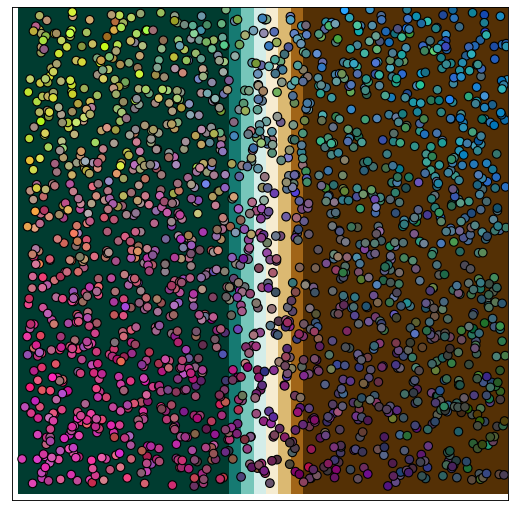

In [47]:
#make your params dict into a proper Geonomics ParamsDict object
params = gnx.make_params_dict(params, 'custom_mod')
#then use it to make a model
mod = gnx.make_model(parameters=params, verbose=True)
# burn in your model
mod.walk(T=10000, mode='burn')
# walk your model (you can change the number of steps you walk)
mod.walk(500)
# plot results
mod.plot_phenotype(spp=0, trt=0)
plot_PCA(mod)
map_PCA(mod, lyr_num=1, mask=False)

<!-- END QUESTION -->

This notebook was developed by Drew Hart, Natalie Graham, Monica Wilkinson and Keeley Takimoto (2019) and contributed to by Anusha Bishop (2020)